# 互联网金融项目

<br>

## 一、项目背景

<br>
&emsp;&emsp;互联网金融的本质是金融，金融的核心在于风控。对于网贷平台来说，风控能力决定了互联网金融企业的竞争力。逾期客户画像主要在于得出未按时还款客户的整体画像，帮助企业降低坏账，给放贷与否给予指导，另外，分析不同维度的不良贷款率情况，以及放贷比例，可以给企业提出一些有效的参考建议。
<br><br>
&emsp;&emsp;该项目数据来自拍拍贷真实业务数据。拍拍贷平台借款端服务包括面向广大个人用户的通用性借款和其他借款，数据是从2015-01-01到2017-01-30的所有信用标的10%的样本。

### 分析目的：

#### 1. 用户基本信息分析

- 不同性别的放贷比例与逾期关系
- 不同年龄的借款情况
- 不同年龄层与坏账的关系

#### 2. 用户行为信息分析

- 不同学历客户的逾期表现
- 其他认证行为客户的逾期表现

## 二、理解数据

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
import os
os.chdir('D:\Data Analysis\ppdai_3_23')
data = pd.read_csv('LCIS.csv', dtype={'ListingId':str})

In [ ]:
data.head()

In [ ]:
data.info()

In [ ]:
data.describe()

## 三、数据处理

In [ ]:
data.rename(columns={'ListingId':'列表序号', 'recorddate':'记录日期'}, inplace = True)

In [ ]:
data.head()

In [ ]:
miss_rate = pd.DataFrame(data.apply(lambda x: sum(x.isnull())/len(x),axis=0))

In [ ]:
miss_rate.columns = ['缺失率']

In [ ]:
miss_rate[miss_rate['缺失率'] >0]['缺失率'].apply(lambda x: format(x, '.3%'))

In [ ]:
data[data['下次计划还款利息'].isnull()].head(10)

In [ ]:
data[data['下次计划还款利息'].isnull()]['标当前状态'].value_counts()[:10]

In [ ]:
data[data['上次还款利息'].isnull()]['标当前状态'].value_counts()[:10]

In [ ]:
data[data['历史成功借款金额'].isnull()]

In [ ]:
data[data['记录日期'].isnull()][['手机认证','户口认证','学历认证', '征信认证', '淘宝认证']]

In [ ]:
data.columns

In [ ]:
# 把记录日期为缺失值的删除，因为是认证错误导致的，数量不多
data.dropna(subset = ['记录日期'], how = 'any', inplace = True)

In [ ]:
data[data.duplicated()]

In [ ]:
data.drop_duplicates(inplace = True)

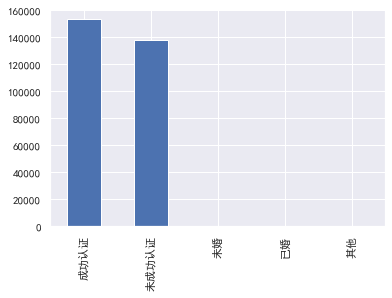

In [45]:
data['手机认证'].value_counts().plot(kind='bar')

In [47]:
data = data[(data['手机认证'] == '成功认证') | (data['手机认证'] == '未成功认证')]

In [52]:
data['户口认证'].value_counts()

未成功认证    269709
成功认证      21521
Name: 户口认证, dtype: int64

## 四、构建模型

#### 1. 不同性别的放贷比例与逾期关系

In [55]:
df_gender = pd.pivot_table(data=data, columns = '标当前状态', index = '性别', values = '列表序号', aggfunc = np.size)

In [60]:
df_gender

标当前状态,已还清,正常还款中,逾期中
性别,,,
女,29881,68967,2857
男,79248,103538,6739


In [61]:
df_gender['借款笔数占比'] = df_gender.apply(np.sum, axis=1) / df_gender.sum().sum()

In [63]:
df_gender['逾期笔数占比'] = df_gender['逾期中'] / df_gender.sum(axis=1)

In [64]:
df_gender

标当前状态,已还清,正常还款中,逾期中,借款笔数占比,逾期笔数占比
性别,,,,,
女,29881,68967,2857,0.349226,0.028091
男,79248,103538,6739,0.650774,0.035557


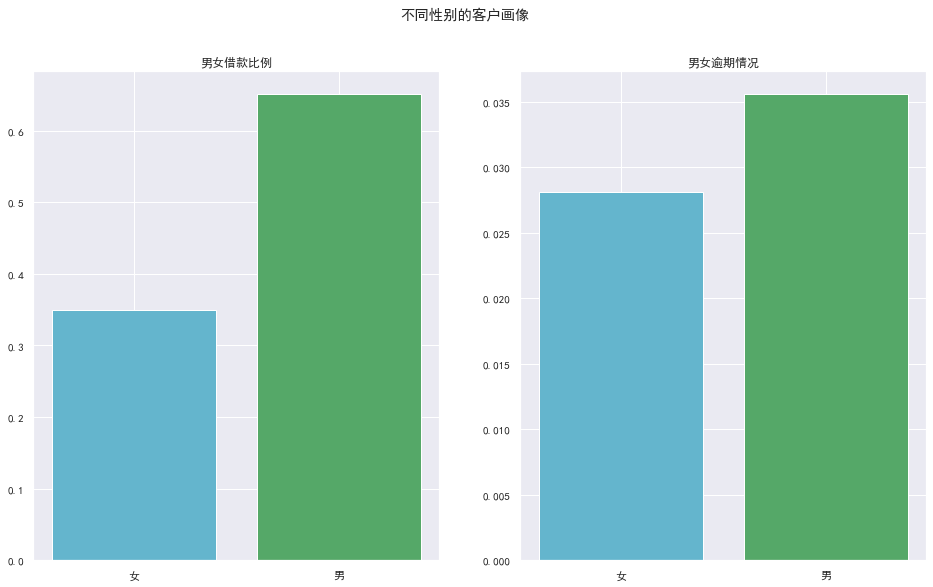

In [66]:
plt.figure(figsize=(16,9))
plt.subplot(121)
plt.bar(x=df_gender.index, height=df_gender['借款笔数占比'], color=['c','g'])
plt.title('男女借款比例')
plt.subplot(122)
plt.bar(x=df_gender.index, height=df_gender['逾期笔数占比'], color=['c','g'])
plt.title('男女逾期情况')
plt.suptitle('不同性别的客户画像')
plt.show()

#### 结论：
- 男性借款人数是女性借款人数的将近2倍，且男性的逾期情况大于女性

#### 2. 不同年龄的借款情况

In [67]:
df_age = data.groupby(['年龄'])['借款金额'].sum()

In [68]:
df_age = pd.DataFrame(df_age)

In [70]:
df_age['借款金额累计'] = df_age['借款金额'].cumsum()

In [72]:
df_age['借款金额累计占比'] = df_age['借款金额累计'] / df_age['借款金额'].sum()

In [84]:
index_num = df_age[df_age['借款金额累计占比'] > 0.8].index[0]

In [85]:
cum_percent = df_age.loc[index_num, '借款金额累计占比']

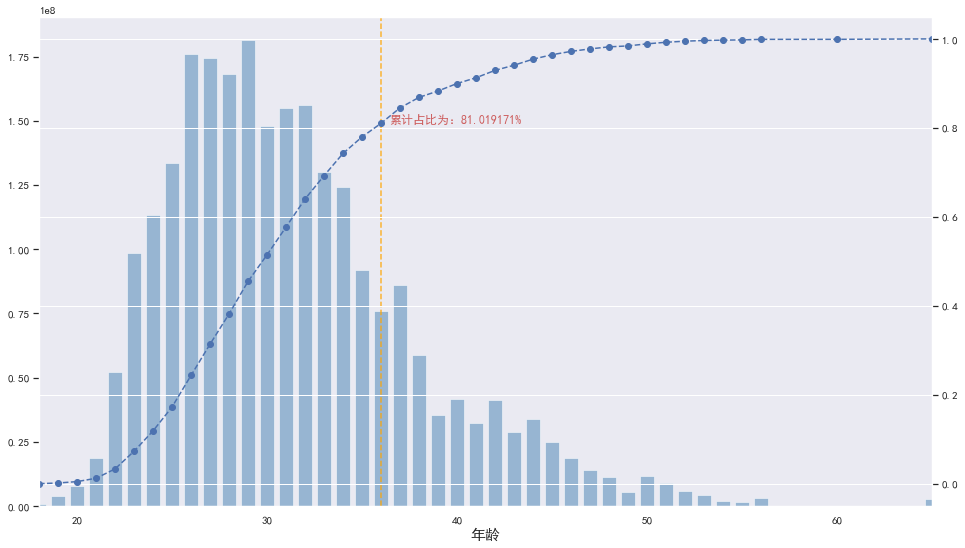

In [91]:
plt.figure(figsize=(16,9))
plt.bar(x=df_age.index, height=df_age['借款金额'], color='steelblue', alpha=0.5, width=0.7)
plt.xlabel('年龄', fontsize=15)
plt.axvline(x=index_num, color='orange', linestyle='--', alpha=0.8)
df_age['借款金额累计占比'].plot(style='--ob', secondary_y=True)
plt.text(index_num+0.4, cum_percent, '累计占比为：%3f%%' % (cum_percent*100), color='indianred')
plt.show()

#### 结论：
- 80%的贷款放给了36岁以下的顾客

#### 3. 不同年龄层与坏账的关系

In [94]:
data['age_bin'] = pd.cut(data['年龄'],[17,24,30,36,42,48,54,65], right=True)
df_age = pd.pivot_table(data=data, columns='标当前状态', index='age_bin', values='列表序号', aggfunc=np.size)# np.size计数

In [95]:
df_age

标当前状态,已还清,正常还款中,逾期中
age_bin,,,
"(17, 24]",21687,38187,2092
"(24, 30]",47594,79216,4023
"(30, 36]",24645,35916,2068
"(36, 42]",9267,11950,881
"(42, 48]",4631,5673,427
"(48, 54]",1225,1467,94
"(54, 65]",80,96,11


In [96]:
df_age['借款笔数'] = df_age.sum(axis=1)

In [97]:
df_age['借款笔数分布'] = df_age['借款笔数'] / df_age['借款笔数'].sum()
df_age['逾期占比'] = df_age['逾期中'] / df_age['借款笔数']

In [98]:
df_age

标当前状态,已还清,正常还款中,逾期中,借款笔数,借款笔数分布,逾期占比
age_bin,,,,,,
"(17, 24]",21687,38187,2092,61966,0.212773,0.033760
"(24, 30]",47594,79216,4023,130833,0.449243,0.030749
"(30, 36]",24645,35916,2068,62629,0.215050,0.033020
"(36, 42]",9267,11950,881,22098,0.075878,0.039868
"(42, 48]",4631,5673,427,10731,0.036847,0.039791
"(48, 54]",1225,1467,94,2786,0.009566,0.033740
"(54, 65]",80,96,11,187,0.000642,0.058824


In [99]:
df_age['借款笔数分布%'] = df_age['借款笔数分布'].apply(lambda x: format(x,'.3%'))
df_age['逾期占比%'] = df_age['逾期占比'].apply(lambda x: format(x, '.3%'))

In [105]:
df_age

标当前状态,已还清,正常还款中,逾期中,借款笔数,借款笔数分布,逾期占比,借款笔数分布%,逾期占比%
age_bin,,,,,,,,
"(17, 24]",21687,38187,2092,61966,0.212773,0.033760,21.277%,3.376%
"(24, 30]",47594,79216,4023,130833,0.449243,0.030749,44.924%,3.075%
"(30, 36]",24645,35916,2068,62629,0.215050,0.033020,21.505%,3.302%
"(36, 42]",9267,11950,881,22098,0.075878,0.039868,7.588%,3.987%
"(42, 48]",4631,5673,427,10731,0.036847,0.039791,3.685%,3.979%
"(48, 54]",1225,1467,94,2786,0.009566,0.033740,0.957%,3.374%
"(54, 65]",80,96,11,187,0.000642,0.058824,0.064%,5.882%


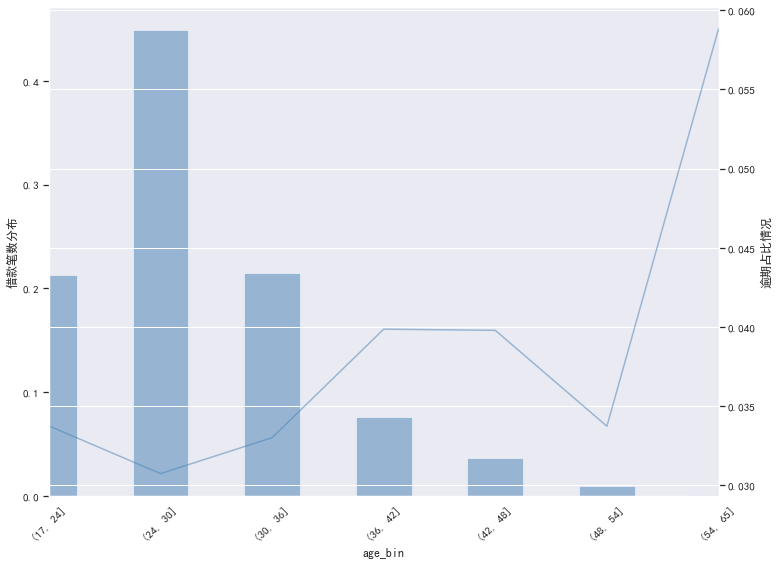

In [106]:
plt.figure(figsize=(12,9))
df_age['借款笔数分布'].plot(kind='bar', rot=45, color='steelblue', alpha=0.5)
plt.xlabel('年龄分段情况')
plt.ylabel('借款笔数分布')
df_age['逾期占比'].plot(rot=45, color='steelblue', alpha=0.5, secondary_y=True)
plt.ylabel('逾期占比情况')
plt.grid(True)
plt.show()

#### 结论：
- 年龄段在25至30岁之间的借款人数最多，占44.9%左右，逾期占比为3.07%，是年龄段中最低的；
- 逾期率最高的年龄段在55岁以上，占5.88%，需要重点关注；

#### 4. 不同学历客户的逾期表现

In [120]:
def trans(data, col, ind):
    df = pd.pivot_table(data=data, columns=col, index=ind, values='列表序号', aggfunc=np.size)
    df['借款笔数'] = df.apply(np.sum, axis=1)
    df['借款笔数占比'] = df['借款笔数'] / df['借款笔数'].sum()
    df['逾期占比'] = df['逾期中'] / df['借款笔数']
    
    plt.figure(figsize=(16,12))
    plt.subplot(121)
    plt.pie(x=df['借款笔数占比'], labels=['成功认证','未成功认证'], 
            colors=['indianred','steelblue'], autopct='%.1f%%', 
            pctdistance=0.5, labeldistance=1.1)
    plt.title('%s比例' % ind)
    plt.subplot(122)
    plt.bar(x=df.index, height=df['逾期占比'],color=['orange','c'])
    plt.title('不同%s的人逾期情况' % ind)
    plt.suptitle('%s客户画像' % ind)
    plt.show()
    return df

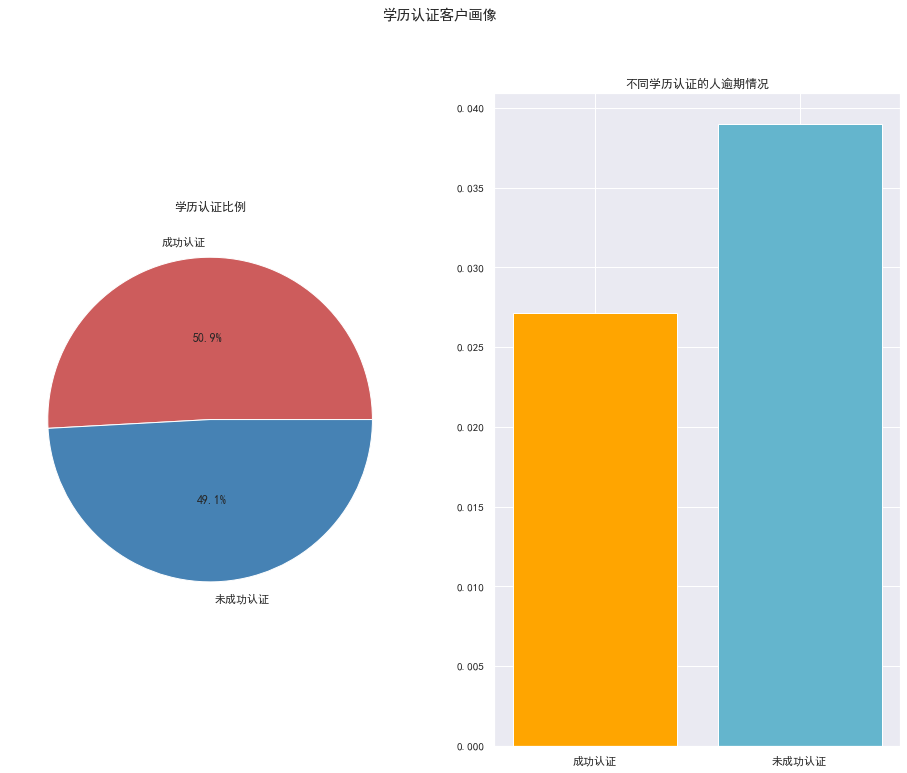

标当前状态,已还清,正常还款中,逾期中,借款笔数,借款笔数占比,逾期占比
学历认证,,,,,,
成功认证,41431,102676,4019,148126,0.508622,0.027132
未成功认证,67698,69829,5577,143104,0.491378,0.038972


In [125]:
trans(data, '标当前状态', '学历认证') # 假设 成功认证=专科及专科以上学历，未成功认证=专科以下学历

#### 结论：
- 学历认证比例几乎是1:1，专科及专科以上的客户比例为50.9%，专科以下的客户比例为49.1%
- 专科及专科以上的客户逾期比例为2.7%，专科以下的客户逾期比例为3.9%，说明学历高的逾期情况好于学历低的客户

#### 5. 其他认证客户的逾期表现

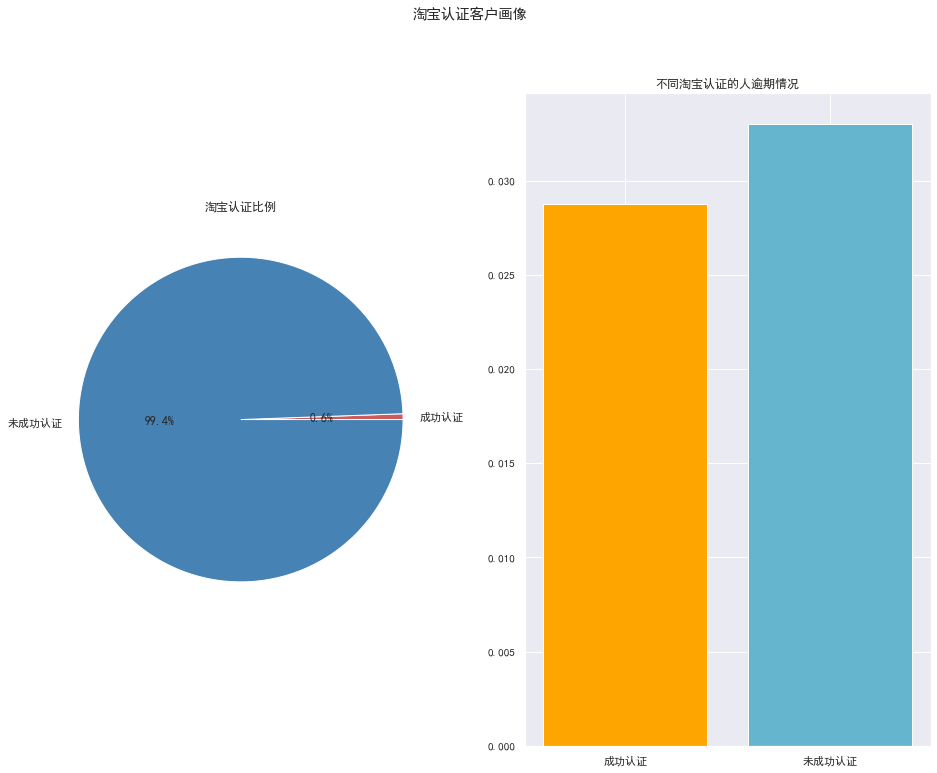

标当前状态,已还清,正常还款中,逾期中,借款笔数,借款笔数占比,逾期占比
淘宝认证,,,,,,
成功认证,1073,549,48,1670,0.005734,0.028743
未成功认证,108056,171956,9548,289560,0.994266,0.032974


In [126]:
trans(data, '标当前状态', '淘宝认证')

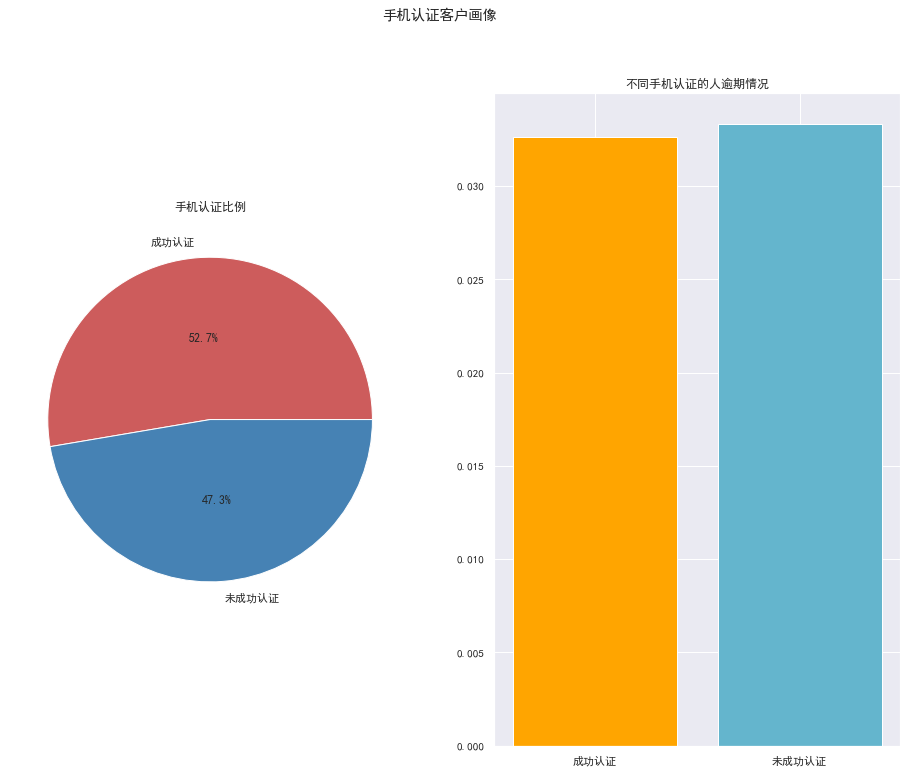

标当前状态,已还清,正常还款中,逾期中,借款笔数,借款笔数占比,逾期占比
手机认证,,,,,,
成功认证,73931,74458,5006,153395,0.526714,0.032635
未成功认证,35198,98047,4590,137835,0.473286,0.033301


In [122]:
trans(data, '标当前状态', '手机认证')

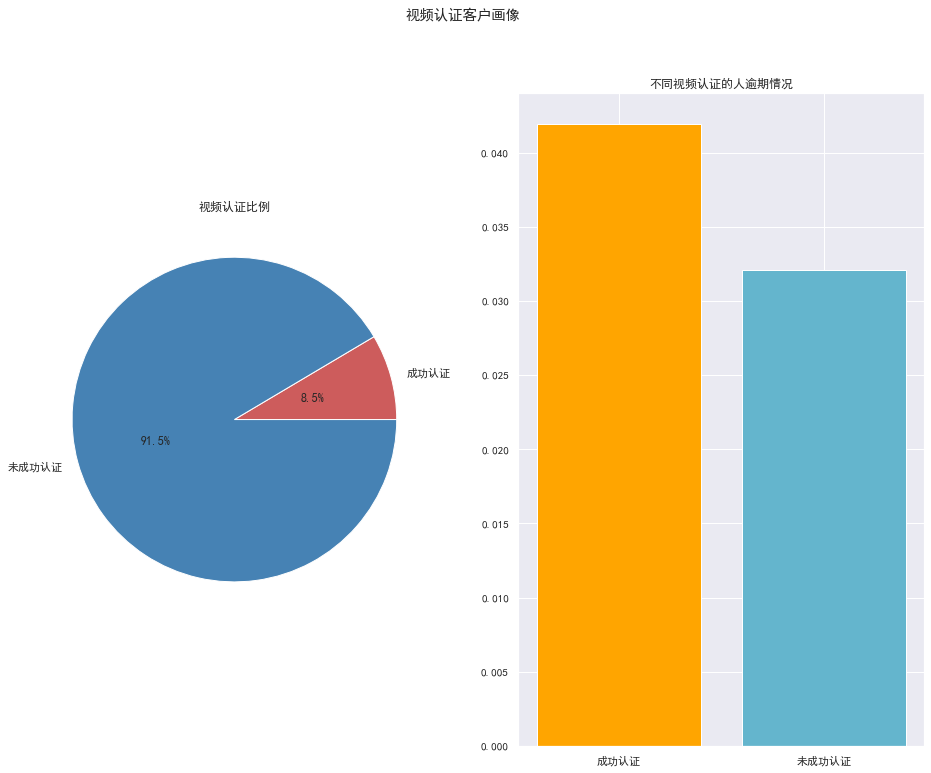

标当前状态,已还清,正常还款中,逾期中,借款笔数,借款笔数占比,逾期占比
视频认证,,,,,,
成功认证,15490,8302,1041,24833,0.085269,0.041920
未成功认证,93639,164203,8555,266397,0.914731,0.032114


In [124]:
trans(data, '标当前状态', '视频认证')

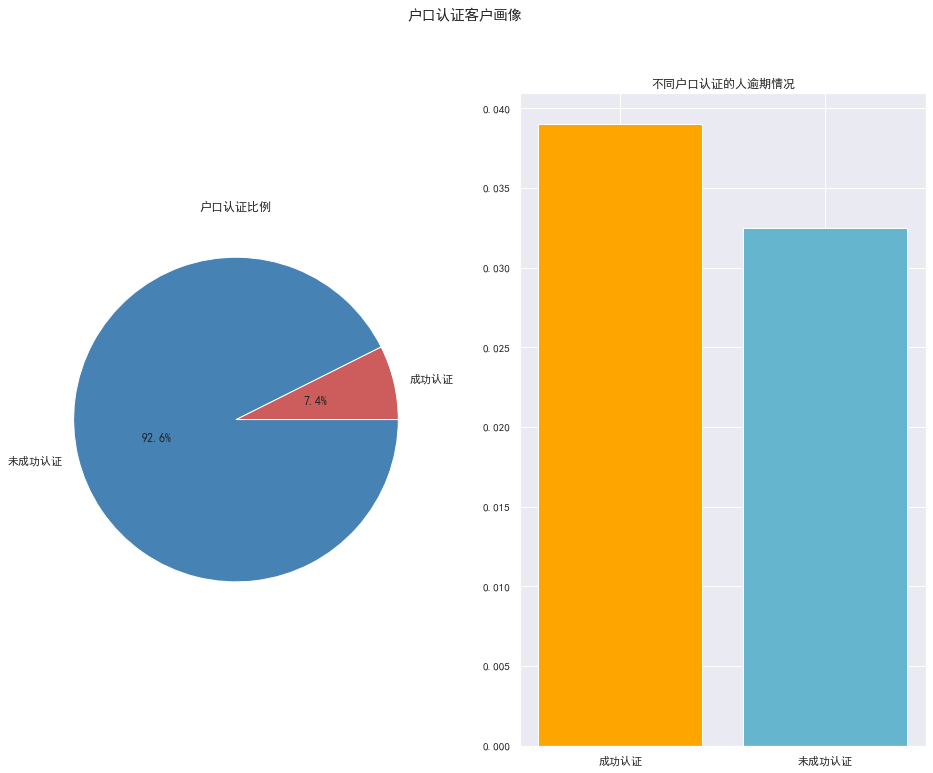

标当前状态,已还清,正常还款中,逾期中,借款笔数,借款笔数占比,逾期占比
户口认证,,,,,,
成功认证,14321,6361,839,21521,0.073897,0.038985
未成功认证,94808,166144,8757,269709,0.926103,0.032468


In [129]:
trans(data, '标当前状态', '户口认证')

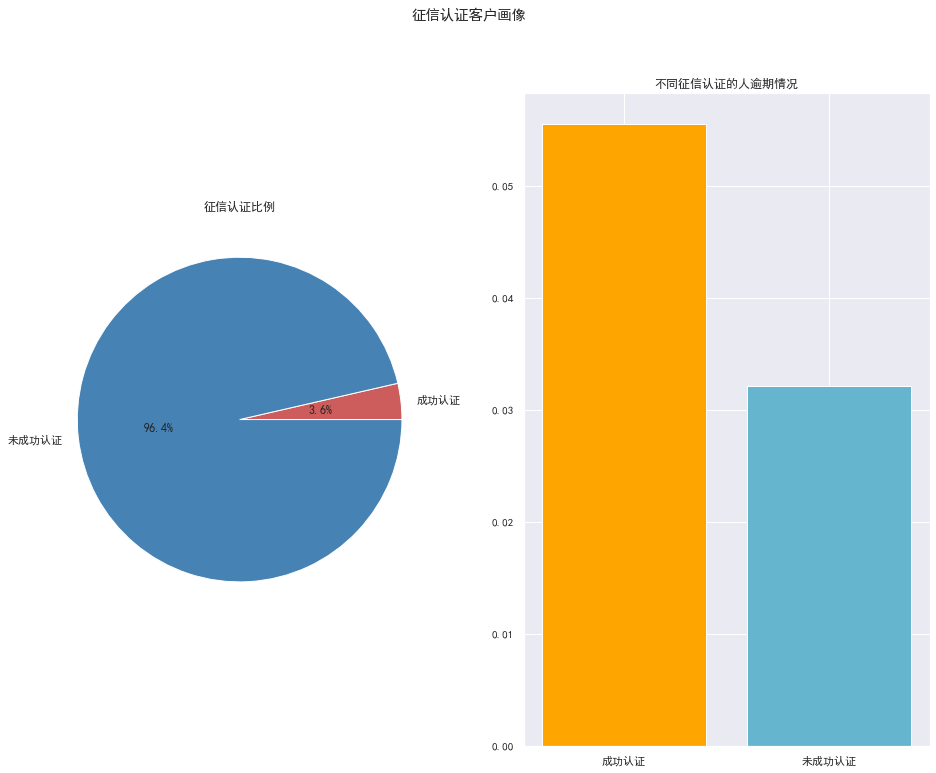

标当前状态,已还清,正常还款中,逾期中,借款笔数,借款笔数占比,逾期占比
征信认证,,,,,,
成功认证,4093,5782,580,10455,0.035899,0.055476
未成功认证,105036,166723,9016,280775,0.964101,0.032111


In [130]:
trans(data, '标当前状态', '征信认证')

#### 结论：
- 视频认证、户口认证和征信认证，认证成功的用户逾期率反而高于未成功认证的用户

## 五、总结建议

#### 1. 性别差异方面：
- 男性借款是女性借款近两倍，逾期表现男性用户也高于女性

#### 2. 年龄分布方面：
- 发现36岁以下的用户借款额占整个平台80%左右，说明36岁以下的人群是平台借款的主力军，而25岁到30岁之间的借款笔数高达45%，说明这是平台的主要使用人群，且逾期占比为3.07%，是比较优质的用户群体，因此针对25-36岁的用户，可以通过做营销活动，尽量吸引这部分人群
- 55岁以上的用户坏账率比较高，因此针对36岁以上，尤其是55岁以上的用户，学历认证是未成功认证的用户，更要严格审核

#### 3. 学历认证方面：
- 进行学历认证和没有进行学历认证的用户是1:1，相比之下进行过学历认证的用户逾期表现会好一点

#### 4. 用户行为方面：
- 视频认证，户口认证和征信认证，认证成功的用户逾期率反而高于未成功认证的逾期率，说明平台不要过多依赖用户认证，对这部分认证成功的用户也要严格审核